## Finding Your Way In The City (Graph Edition)
In this notebook your attention will shift from grids to graphs. At least for search ... 

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.

In [1]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1
# import pkg_resources
# pkg_resources.require("networkx==2.1")

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for networkx: filename=networkx-2.1-py2.py3-none-any.whl size=1446300 sha256=8ee2cf4aabdda1fcc0fca4d2e137b52715f72c575a90bf288e44150511f2f4b0
  Stored in directory: c:\users\bln00\appdata\local\pip\cache\wheels\73\23\af\0b183d0c311bbd174d61613a506bc22c7134eca8878d09aec0
Successfully built networkx


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 6.5.1 requires ipykernel>=6.14, but you have ipykernel 5.5.5 which is incompatible.
jupyter-console 6.5.1 requires jupyter-core!=5.0.*,>=4.12, but you have jupyter-core 4.8.1 which is incompatible.
jupyter-console 6.5.1 requires traitlets>=5.4, but you have traitlets 4.3.3 which is incompatible.


In [228]:
import networkx as nx
nx.__version__

'2.1'

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from grid_v2 import create_grid_and_edges
import numpy.linalg as LA
%matplotlib inline 

In [230]:
plt.rcParams['figure.figsize'] = 12, 12

In [231]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [232]:
start_ne = (25,  100)
goal_ne = (750., 370.)

In [233]:
# Static drone altitude (metres)
drone_altitude = 5
safety_distance = 3

In [234]:
# This is now the routine using Voronoi
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print(len(edges))

1895


Plot the edges on top of the grid along with start and goal locations.

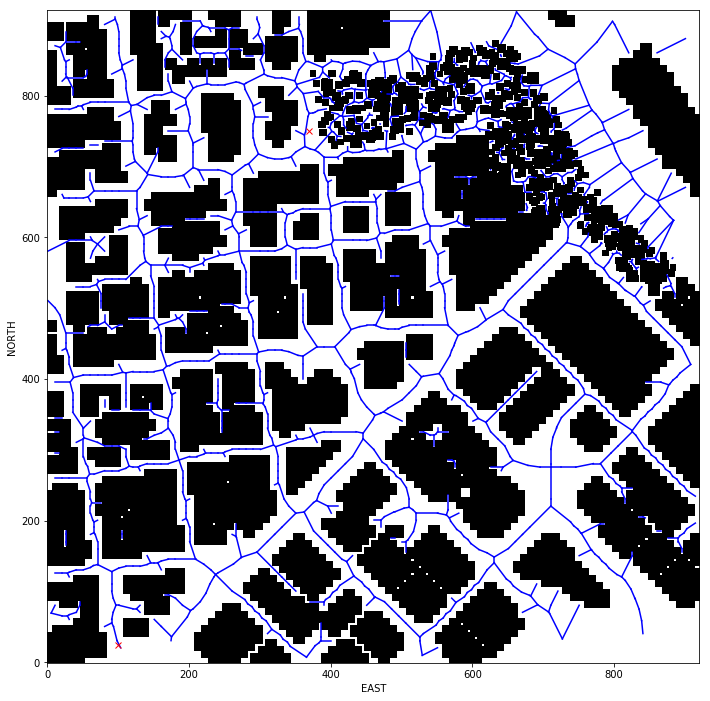

In [235]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

We now have a graph, well at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph. **NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms.

**NOTE:** In the initial import above it was imported with the `nx` alias.

You're encouraged to read the documentation but here's a super quick tour:

1. Create a graph:

```
G = nx.Graph()
```

2. Add an edge:

```
p1 = (10, 2.2)
p2 = (50, 40)
G = nx.add_edge(p1, p2)
```

3 Add an edge with a weight:

```
p1 = (10, 2.2)
p2 = (50, 40)
dist = LA.norm(np.array(p2) - np.array(p1))
G = nx.add_edge(p1, p2, weight=dist)
```

In [236]:
# TODO: create the graph with the weight of the edges
# set to the Euclidean distance between the points
w_edges = [(p1,p2, LA.norm(np.array(p2) - np.array(p1))) for p1,p2 in edges]
G = nx.Graph()
G.add_weighted_edges_from(w_edges)

In [237]:
len(G.edges)

1895

You need a method to search the graph, and you'll adapt A* in order to do this. The notable differences being the actions are now the outgoing edges and the cost of an action is that weight of that edge.

In [238]:
from queue import PriorityQueue

def heuristic_func(position, goal_position , method = 'Euclidean' ):
    # TODO: define a heuristic    
    if method == 'Euclidean':
        h = ((position[0]-goal_position[0])**2 + (position[1]-goal_position[1])**2)**0.5
    elif method == 'Manhattan':
        h = abs(position[0]-goal_position[0]) + abs(position[1]-goal_position[1])
    else:
        print('Warning!!! Unknown method - {} \n return h=0 '.format(method))
        h = 0
            
    return h

In [240]:
def find_start_goal_in_graph(G, start, goal):
    # TODO: find start and goal on skeleton
    # Some useful functions might be:
        # np.nonzero()
        # np.transpose()
        # np.linalg.norm()
        # np.argmin()

    idx = np.argmin([((start[0]-x)**2 + (start[1]-y)**2) for x,y in G.nodes])
    node_start = list(G.nodes)[idx]
    
    idx = np.argmin([((goal[0]-x)**2 + (goal[1]-y)**2) for x,y in G.nodes])
    node_goal = list(G.nodes)[idx]
    return node_start, node_goal

In [243]:
###### THIS IS YOUR OLD GRID-BASED A* IMPLEMENTATION #######
###### With a few minor modifications it can work with graphs! ####
#TODO: modify A* to work with a graph
def a_star_graph(G, h, start_n, goal_n):
    paths = []
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start_n))
    visited = set(start_n)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start_n:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal_n:        
            print('Found a path.')
            found = True 
            break
        else:
            for next_node in G[current_node]:
                w = G[current_node][next_node]['weight']
                # get the tuple repre.values())[0]['weight']sentation
                branch_cost = current_cost + G[current_node][next_node]['weight']
                queue_cost = branch_cost + h(next_node, goal_n)
                
                if next_node not in visited: 
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node, next_node)
                    queue.put((queue_cost, next_node))
                else:
                    if branch_cost < branch[next_node][0]:
                        branch[next_node] = (branch_cost, current_node, next_node)
                        queue.put((queue_cost, next_node))
                        
             
    if found:
        # retrace steps
        n = goal_n
        path_cost = branch[n][0]
        path.append(goal_n)
        while branch[n][1] != start_n:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost

### Solution

This solution consists of two parts:

1. Find the closest point in the graph to our current location, same thing for the goal location.
2. Compute the path from the two points in the graph using the A* algorithm.
3. Feel free to use any of the path pruning techniques to make the path even smaller! 
4. Plot it up to see the results!

In [117]:
g_start, g_goal = find_start_goal_in_graph(G, start_ne, goal_ne)
#path_aStar , cost_aStar = a_star(grid, h, start, goal)

In [244]:
# Compare to regular A* on the grid
path, cost =  a_star_graph(G, heuristic_func, g_start, g_goal)
print('path length {} ; path cost {:0.2f}'.format(len(path),cost))

Found a path.
path length 97 ; path cost 1050.29


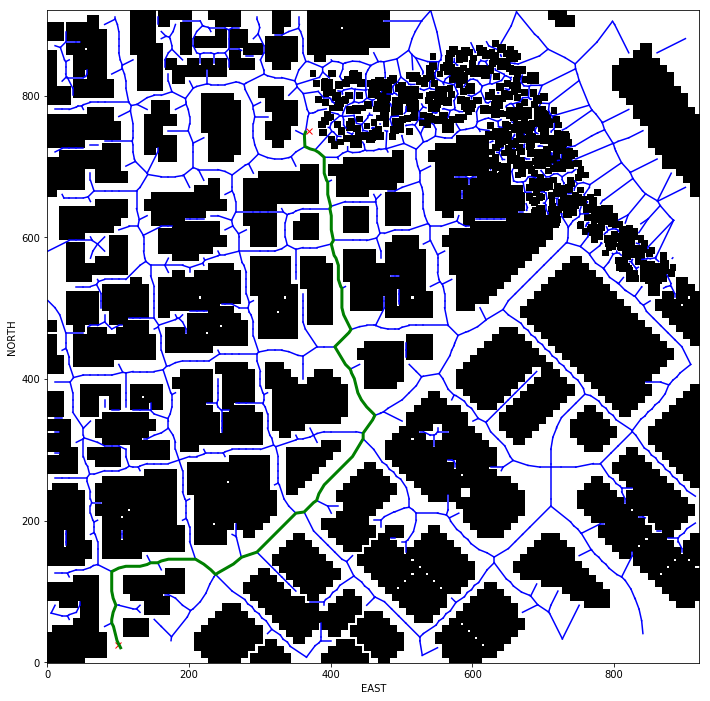

In [245]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'xr')
# Uncomment the following as needed
plt.plot(goal_ne[1], goal_ne[0], 'xr')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g', linewidth=3)


plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()